# Recipe5k Model

## Install and Import Necessary Libraries

In [1]:
!pip install -U fastbook torchtext==0.8.1

     |████████████████████████████████| 727kB 28.4MB/s 
     |████████████████████████████████| 7.0MB 18.4MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 204kB 53.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import json
import pandas as pd

# Mount Personal Google Drive (Where Data is Located)

In order to use the Recipes5k data, we mounted the dataset to our personal google drive folders. Colab makes it somewhat difficult to use your own local file system so this was the easiest option (outside simply calling a link within the code). You can find and download the link here -  http://www.ub.edu/cvub/recipes5k/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

In [4]:
def get_img_paths(path):
  train_img_paths = []
  img_path = '/content/drive/MyDrive/Recipes5k/Recipes5k/images/'
  with open(path) as f:
    for line in f:
      train_img_paths.append(img_path + line.strip())
  return train_img_paths

def get_ings(idxPath, ingPath, trainSet = None):
  train_ing_indices = []
  with open(idxPath) as f:
    for line in f:
      train_ing_indices.append(int(line.strip()))
  train_ingredients = []
  with open(ingPath) as f:
    for line in f:
      ings = line.rstrip('\n').split(',')
      new_ings = []
      for ing in ings:
        if not trainSet or ing in trainSet:
          new_ings.append(ing)
      train_ingredients.append(new_ings)
  mapped_train_ingredients = []
  for idx in train_ing_indices:
    mapped_train_ingredients.append(train_ingredients[idx])
  return mapped_train_ingredients
  

train_img_paths = get_img_paths('/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/train_images.txt')
valid_img_paths = get_img_paths('/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/val_images.txt')
train_ings = get_ings('/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/train_labels.txt', '/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/ingredients_simplified_Recipes5k.txt')
trainSet = set()
for l in train_ings:
  for ing in l:
    trainSet.add(ing)
valid_ings = get_ings('/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/val_labels.txt', '/content/drive/MyDrive/Recipes5k/Recipes5k/annotations/ingredients_simplified_Recipes5k.txt',trainSet)
print(len(train_img_paths), len(train_ings), len(valid_img_paths), len(valid_ings))

3409 3409 634 634


In [5]:
df_data = {'image': train_img_paths + valid_img_paths,
           'labels': train_ings + valid_ings,
           'train' : [True for _ in range(len(train_img_paths))] + [False for _ in range(len(valid_img_paths))]}
df = pd.DataFrame(df_data, columns = ['image', 'labels', 'train'])
df.head()



,image,labels,train
0,/content/drive/MyDrive/Recipes5k/Recipes5k/images/apple_pie/20_homemade_apple_pie_hostedLargeUrl.jpg,"[flour, salt, oil, cold water, apple, sugar, cinnamon, butter]",True
1,/content/drive/MyDrive/Recipes5k/Recipes5k/images/apple_pie/43_homestyle_apple_pie_hostedLargeUrl.jpg,"[shell, pie, sugar, flour, cinnamon, apple, lemon, butter, milk]",True
2,/content/drive/MyDrive/Recipes5k/Recipes5k/images/apple_pie/28_apple_pie_hostedLargeUrl.jpg,"[apple, lemon, sugar, flour, cinnamon, nut, butter, salt, butter, ice water]",True
3,/content/drive/MyDrive/Recipes5k/Recipes5k/images/apple_pie/39_classic_apple_pie_hostedLargeUrl.jpg,"[pie, apple, sugar, corn starch, cinnamon, lemon, butter, egg, cold water]",True
4,/content/drive/MyDrive/Recipes5k/Recipes5k/images/apple_pie/13_mug_apple_pie_hostedLargeUrl.jpg,"[apple, brown sugar, butter, cinnamon, allspice, nut, pie]",True


# Assemble DataBlock/DataLoader

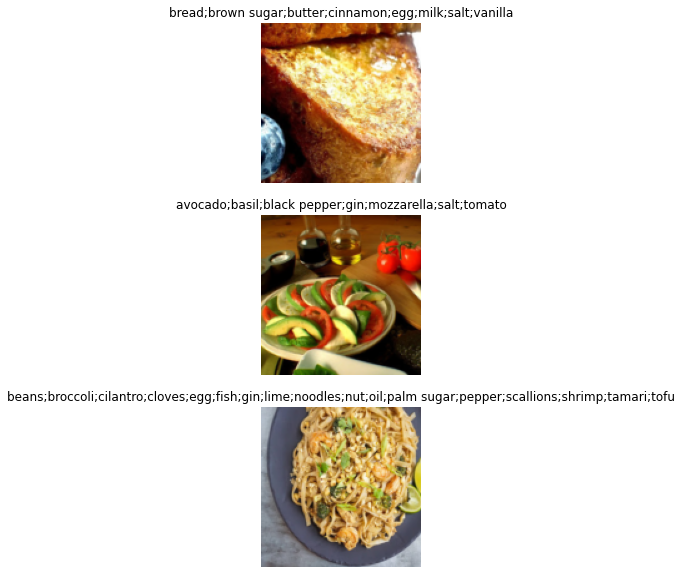

In [6]:
def get_x(r): return r['image']
def get_y(r): return r['labels']

def splitter(df):
    train = df.index[df['train']].tolist()
    valid = df.index[~df['train']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(nrows=3, ncols=1, figsize=(10,10))

# Learn!

In [7]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.978530,0.689495,0.109140,08:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.747656,0.546150,0.116474,00:18
1,0.479920,0.178205,0.899279,00:18
2,0.243571,0.081804,0.986103,00:18
3,0.137407,0.066434,0.986549,00:19
4,0.095661,0.064579,0.986575,00:19


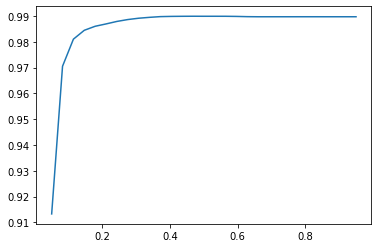

In [8]:
preds,targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Compare Predictions and Actual

/content/drive/MyDrive/Recipes5k/Recipes5k/images/carrot_cake/5_homemade_carrot_cake_hostedLargeUrl.jpg


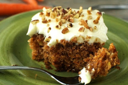

['black pepper',
 'butter',
 'cheese',
 'egg',
 'flour',
 'garlic',
 'oil',
 'onion',
 'pepper',
 'salt',
 'sugar']

In [9]:
def predict_ingredients(img_path):
  print(img_path)
  img = PILImage.create(img_path)
  display(img.to_thumb(128,128))
  preds = learn.predict(img)
  preds_list = preds[-1].tolist()
  pred_idxs = [preds_list.index(elem) for elem in preds_list if(elem > 0.15)]
  pred_dict = {}
  pred_list = []
  for idx in pred_idxs:
    pred_dict[idx] = dls.vocab[idx]
    pred_list.append(dls.vocab[idx])
  return pred_list

predict_ingredients('/content/drive/MyDrive/Recipes5k/Recipes5k/images/carrot_cake/5_homemade_carrot_cake_hostedLargeUrl.jpg')

In [10]:
df.loc[df['image'] == '/content/drive/MyDrive/Recipes5k/Recipes5k/images/carrot_cake/5_homemade_carrot_cake_hostedLargeUrl.jpg']



,image,labels,train
184,/content/drive/MyDrive/Recipes5k/Recipes5k/images/carrot_cake/5_homemade_carrot_cake_hostedLargeUrl.jpg,"[butter, sugar, brown sugar, oil, egg, vanilla, flour, baking, salt, cinnamon, nut, carrot, apple, pecan, cheese, butter, sugar]",True


/content/drive/MyDrive/Recipes5k/Recipes5k/images/paella/9_stovetop_paella_with_chorizo_and_chicken_hostedLargeUrl.jpg


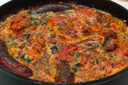

['black pepper',
 'butter',
 'cheese',
 'egg',
 'flour',
 'garlic',
 'gin',
 'oil',
 'onion',
 'pepper',
 'salt',
 'sugar']

In [11]:
predict_ingredients('/content/drive/MyDrive/Recipes5k/Recipes5k/images/paella/9_stovetop_paella_with_chorizo_and_chicken_hostedLargeUrl.jpg')



In [12]:
df.loc[df['image'] == '/content/drive/MyDrive/Recipes5k/Recipes5k/images/paella/9_stovetop_paella_with_chorizo_and_chicken_hostedLargeUrl.jpg']


,image,labels,train
79,/content/drive/MyDrive/Recipes5k/Recipes5k/images/paella/9_stovetop_paella_with_chorizo_and_chicken_hostedLargeUrl.jpg,"[chicken, saffron, oil, bones, chorizo, onion, cloves, tomato, paprika, pepper, paella, pepper, egg, parsley, lemon, nut, lemon]",True
